In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv("auto.csv")

# Binary encoding for columns with 2 unique options
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
for col in binary_cols:
    unique_values = df[col].unique()
    df[col] = df[col].apply(lambda x: 1 if x == unique_values[0] else 0)

# One-Hot Encoding for remaining categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Normalize numeric features
scaler = StandardScaler()
numeric_cols = ['km', 'age', 'hp_kW', 'Displacement_cc', 'Weight_kg', 'cons_comb']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Apply log transformation to the target
df['price'] = np.log1p(df['price'])

# Define features (X) and target (y)
X = df.drop('price', axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a custom PyTorch Dataset
class AutoDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

# Create PyTorch Datasets
train_dataset = AutoDataset(X_train_tensor, y_train_tensor)
test_dataset = AutoDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Number of training samples: 12732
Number of testing samples: 3183


In [36]:
numeric_cols = ['km', 'age', 'hp_kW', 'Displacement_cc', 'Weight_kg', 'cons_comb']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

scaled_stats = df[numeric_cols].describe()
print(scaled_stats)

                 km           age         hp_kW  Displacement_cc  \
count  1.591500e+04  1.591500e+04  1.591500e+04     1.591500e+04   
mean   2.143013e-17 -7.143377e-18  2.857351e-17     1.428675e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00     1.000031e+00   
min   -8.678589e-01 -1.239393e+00 -1.818259e+00    -1.953120e+00   
25%   -8.159198e-01 -1.239393e+00 -8.435090e-01    -7.239488e-01   
50%   -3.157989e-01 -3.475478e-01 -1.311916e-01     1.172539e-01   
75%    4.005296e-01  5.442973e-01  5.436354e-01     6.139986e-01   
max    7.705257e+00  1.436142e+00  7.704300e+00     5.577819e+00   

          Weight_kg     cons_comb  
count  1.591500e+04  15915.000000  
mean   6.429039e-17      0.000000  
std    1.000031e+00      1.000031  
min   -2.492539e+00     -2.111952  
25%   -8.649033e-01     -0.843944  
50%   -2.138490e-01     -0.037030  
75%    6.725865e-01      0.654611  
max    5.675689e+00      4.919728  


Skewness of price: -0.03


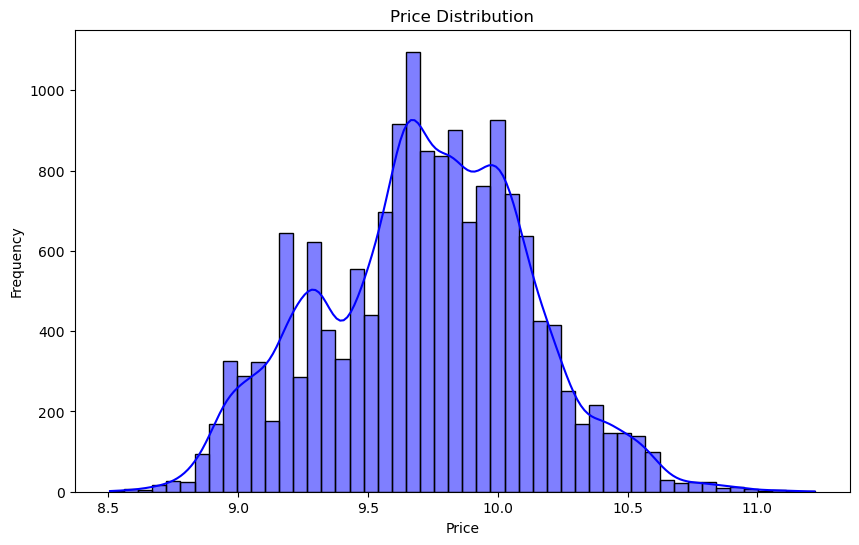

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

skewness = df['price'].skew()
print(f'Skewness of price: {skewness:.2f}')
# Plot price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Because the skewness is already close to zero, there is no need for a log transformation.

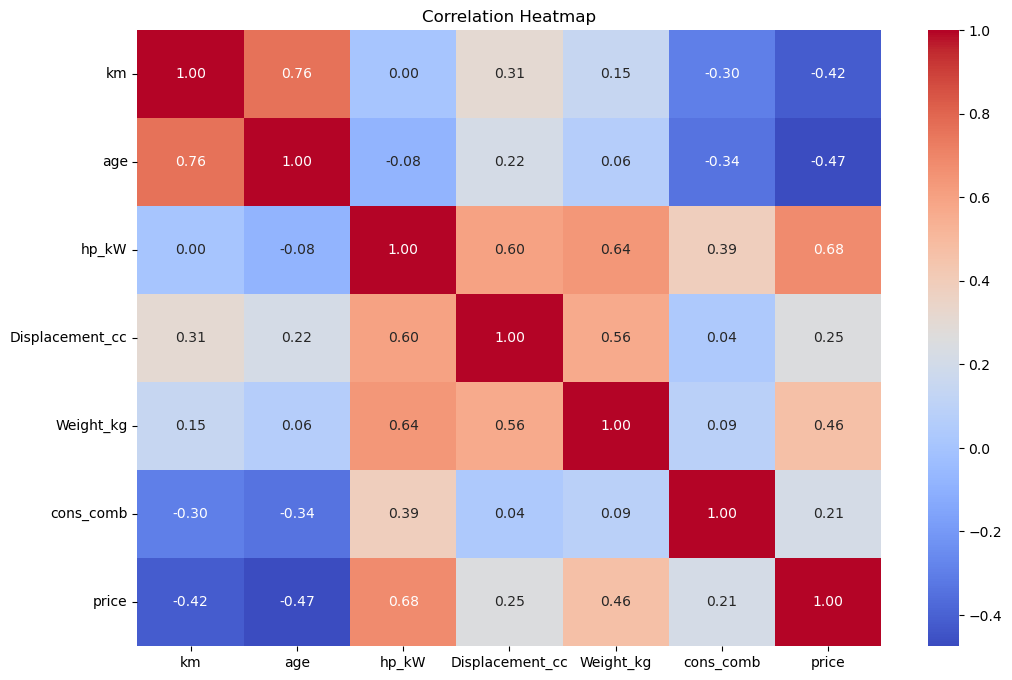

In [8]:
numerical_cols = ['km', 'age', 'hp_kW', 'Displacement_cc', 'Weight_kg', 'cons_comb', 'price']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


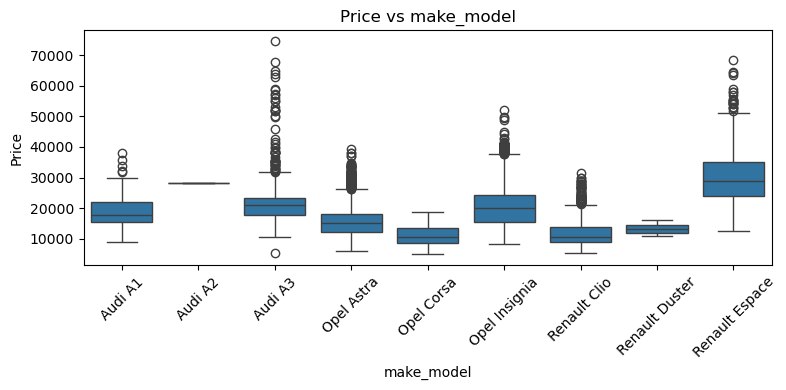

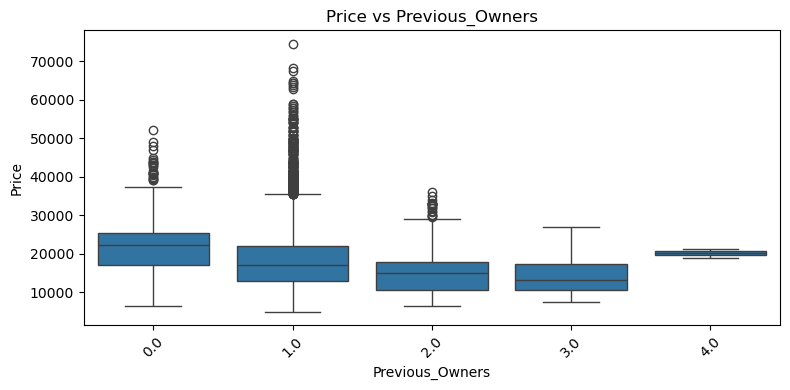

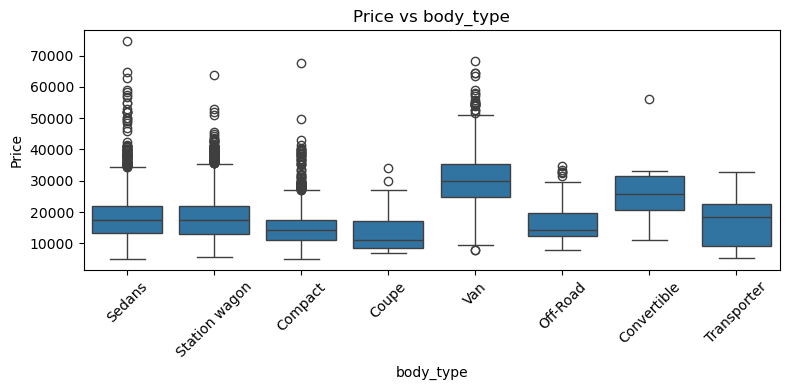

In [12]:
categorical_cols_subset = ['make_model', 'Previous_Owners', 'body_type']
raw_df = pd.read_csv("auto.csv")
df_visual = raw_df.copy()  # Correctly copy raw_df into df_visual

for col in categorical_cols_subset:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_visual[col], y=df_visual['price'])
    plt.xticks(rotation=45)
    plt.title(f"Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

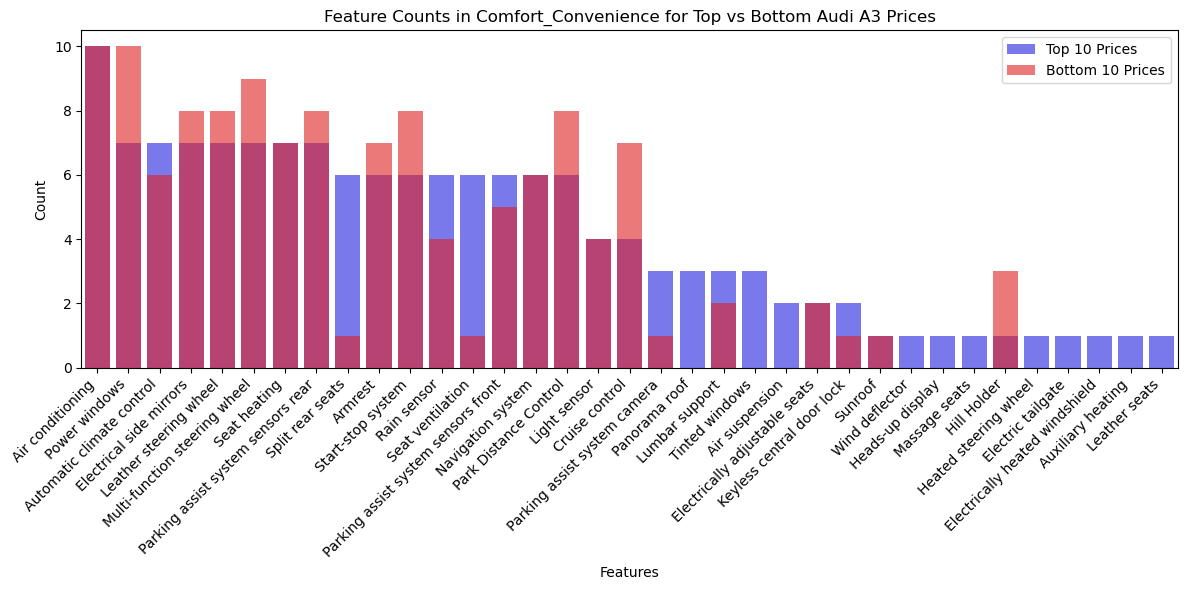

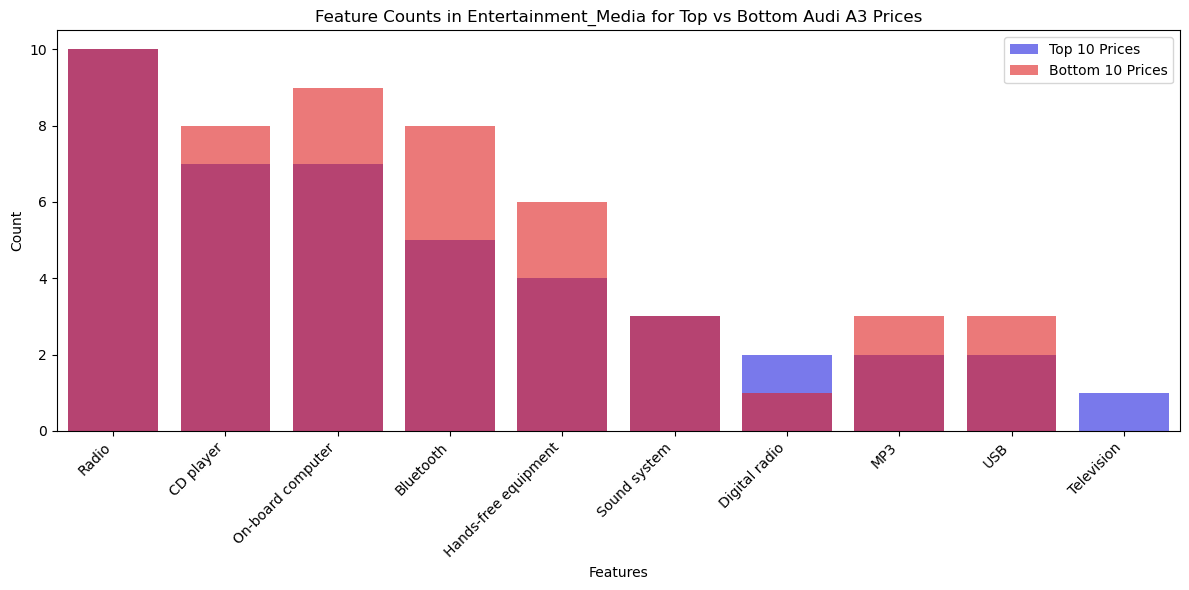

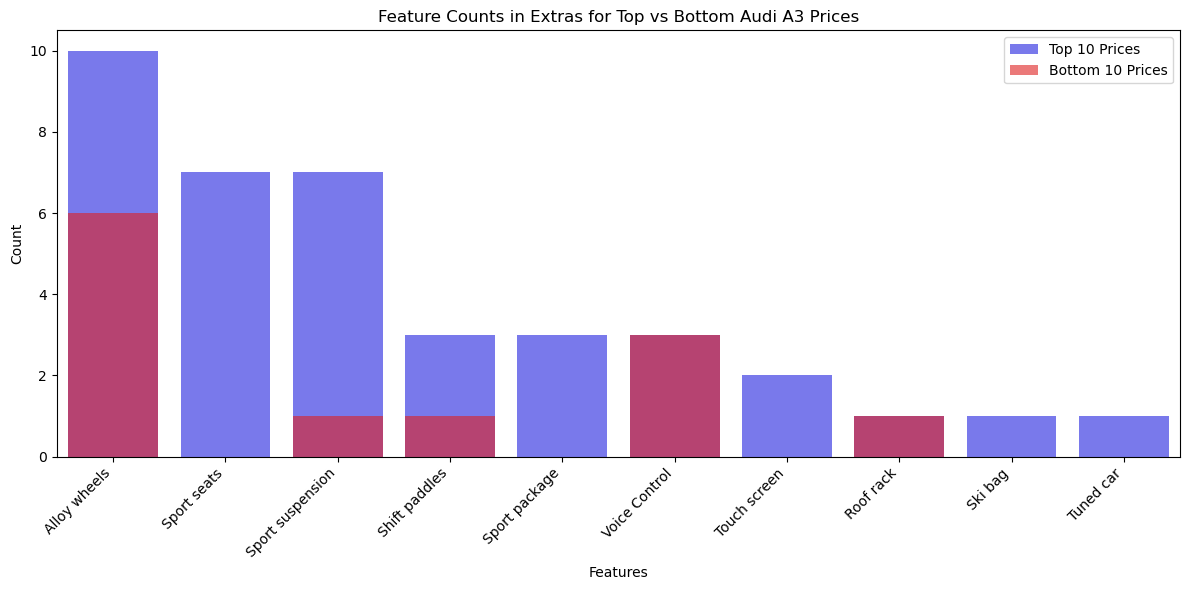

In [14]:
# Filter top 10 highest and lowest-priced Audi A3s
top_10_audi = raw_df[raw_df['make_model'] == 'Audi A3'].nlargest(10, 'price')
bottom_10_audi = raw_df[raw_df['make_model'] == 'Audi A3'].nsmallest(10, 'price')

# Categories to analyze
categories = ['Comfort_Convenience', 'Entertainment_Media', 'Extras']

def count_features(df, category):
    feature_counts = {}
    for features in df[category]:
        if pd.notna(features):
            for feature in features.split(','):
                feature = feature.strip()
                feature_counts[feature] = feature_counts.get(feature, 0) + 1
    return feature_counts

for category in categories:
    top_counts = count_features(top_10_audi, category)
    bottom_counts = count_features(bottom_10_audi, category)

    feature_data = pd.DataFrame({
        'Feature': list(top_counts.keys()),
        'Top 10 Count': list(top_counts.values()),
        'Bottom 10 Count': [bottom_counts.get(feature, 0) for feature in top_counts.keys()]
    }).sort_values(by='Top 10 Count', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_data, x='Feature', y='Top 10 Count', label='Top 10 Prices', color='blue', alpha=0.6)
    sns.barplot(data=feature_data, x='Feature', y='Bottom 10 Count', label='Bottom 10 Prices', color='red', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Feature Counts in {category} for Top vs Bottom Audi A3 Prices')
    plt.xlabel('Features')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


This box plot checks for outliers

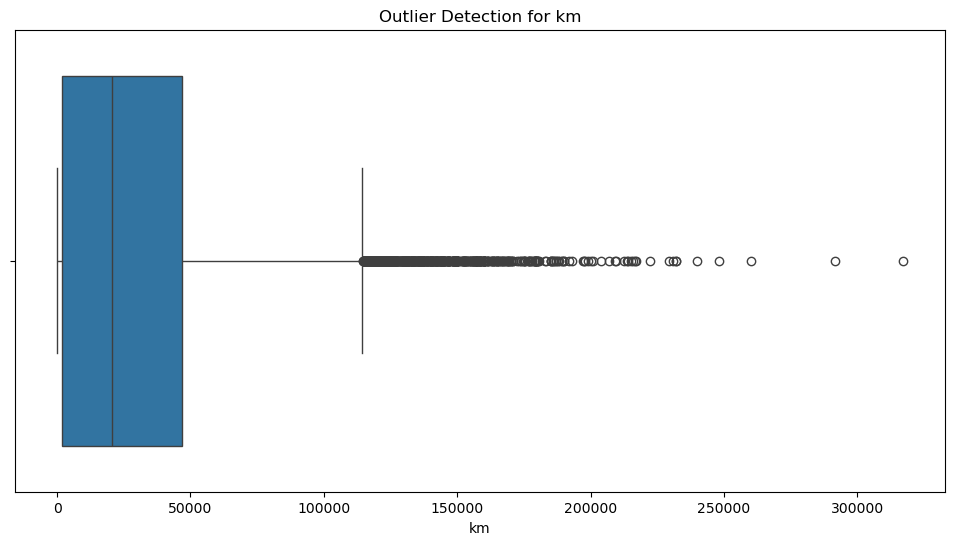

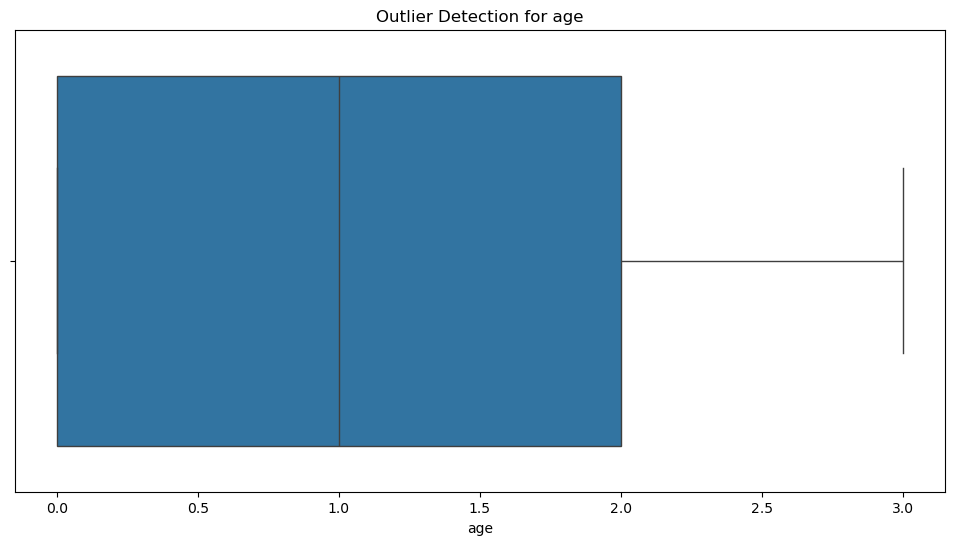

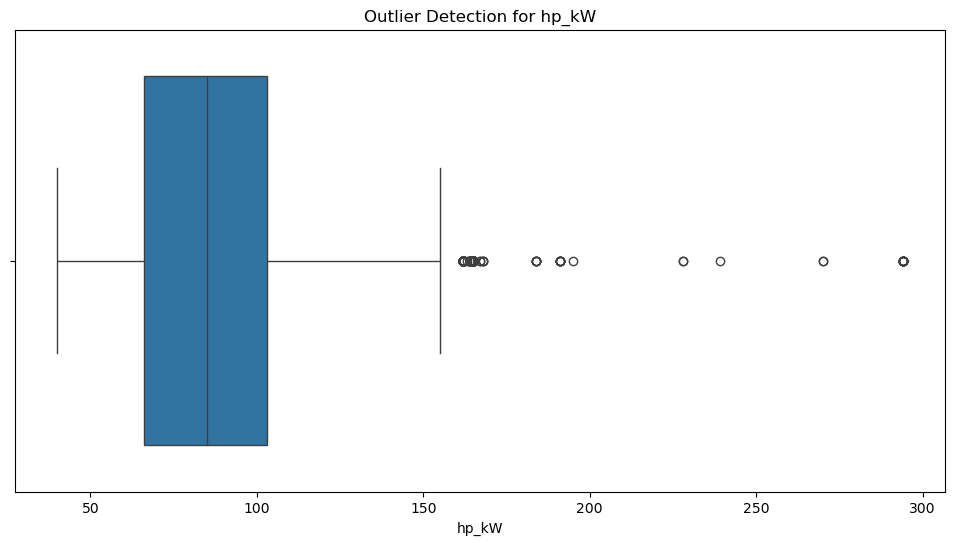

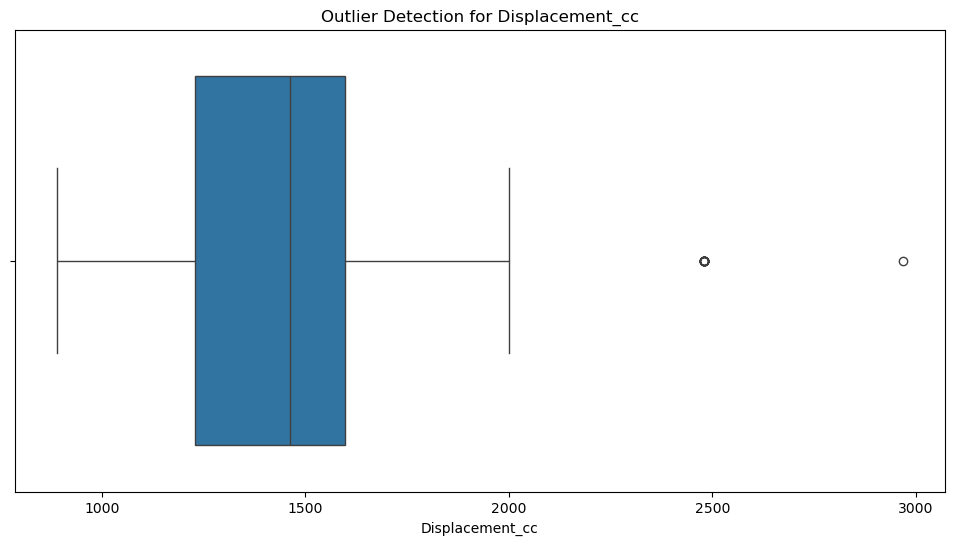

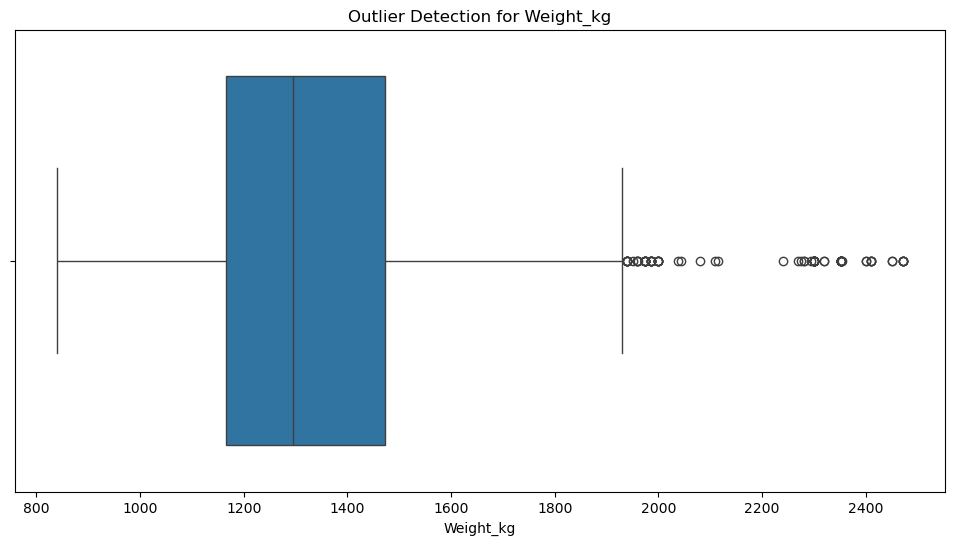

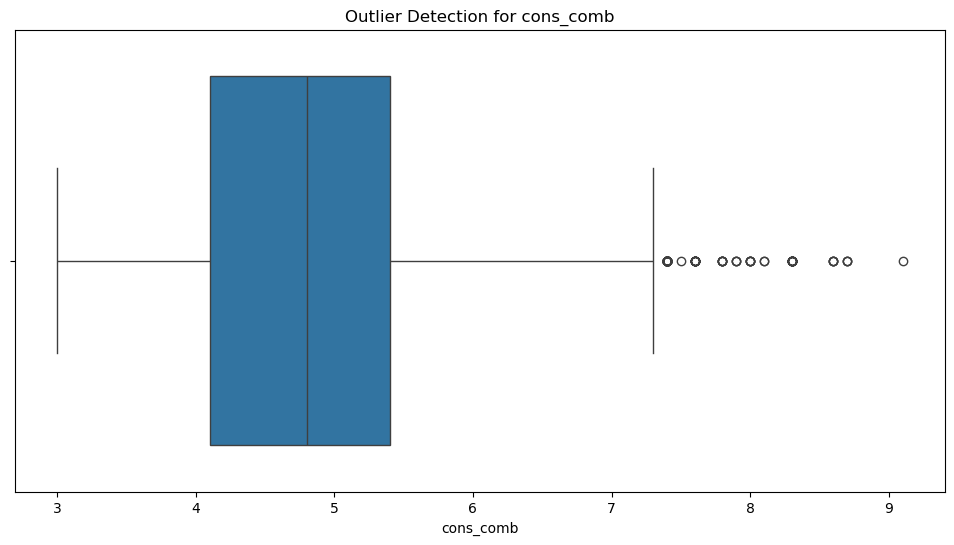

In [17]:
for col in numerical_cols[:-1]: 
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=raw_df[col])  # Use raw_df here
    plt.title(f"Outlier Detection for {col}")
    plt.xlabel(col)
    plt.show()

Noticing signifcant outliers in the KM section so lets see if they are real or bad data

In [20]:
top_20_km_raw = raw_df.nlargest(20, 'km')[['km']]
print(top_20_km_raw)

             km
9275   317000.0
3003   291800.0
5712   260000.0
6223   248000.0
15273  240000.0
10800  232000.0
6379   231879.0
6062   230928.0
6398   229500.0
10491  222346.0
3218   217032.0
10844  216560.0
10746  215968.0
11175  214999.0
10850  214000.0
10852  213687.0
6056   212569.0
6315   209467.0
3228   209000.0
2987   207000.0


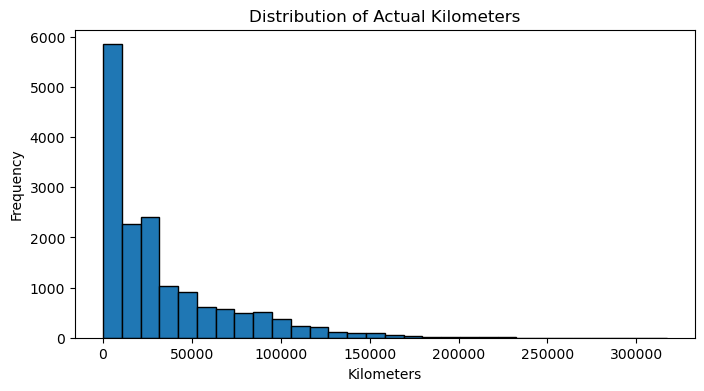

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(raw_df['km'], bins=30, edgecolor='k')  # Use the raw 'km' column from raw_df
plt.title("Distribution of Actual Kilometers")
plt.xlabel("Kilometers")
plt.ylabel("Frequency")
plt.show()

In [24]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score

class AutoNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoNN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_size // 2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.output(x)
        return x

# Model parameters
input_size = X_train.shape[1]
hidden_size = 128
num_epochs = 200
learning_rate = 0.01

# Initialize the model, loss function, and optimizer
model = AutoNN(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [154]:

for epoch in range(num_epochs):
    model.train()
    for features, targets in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).view(-1, 1)
    mse = criterion(y_pred, y_test_tensor).item()
    r2 = r2_score(y_test_tensor.numpy(), y_pred.numpy())
    mape = torch.mean(torch.abs((y_test_tensor - y_pred) / y_test_tensor)).item() * 100
    print(f"Mean Squared Error on Test Data: {mse:.4f}")
    print(f"R-squared (R²) on Test Data: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Epoch [1/200], Loss: 0.4230
Epoch [2/200], Loss: 0.0570
Epoch [3/200], Loss: 0.0737
Epoch [4/200], Loss: 0.0261
Epoch [5/200], Loss: 0.0387
Epoch [6/200], Loss: 0.0507
Epoch [7/200], Loss: 0.1026
Epoch [8/200], Loss: 0.0152
Epoch [9/200], Loss: 0.0389
Epoch [10/200], Loss: 0.0173
Epoch [11/200], Loss: 0.0267
Epoch [12/200], Loss: 0.0135
Epoch [13/200], Loss: 0.0216
Epoch [14/200], Loss: 0.0084
Epoch [15/200], Loss: 0.0180
Epoch [16/200], Loss: 0.0099
Epoch [17/200], Loss: 0.0095
Epoch [18/200], Loss: 0.0108
Epoch [19/200], Loss: 0.0056
Epoch [20/200], Loss: 0.0051
Epoch [21/200], Loss: 0.0033
Epoch [22/200], Loss: 0.0052
Epoch [23/200], Loss: 0.0109
Epoch [24/200], Loss: 0.0033
Epoch [25/200], Loss: 0.0030
Epoch [26/200], Loss: 0.0031
Epoch [27/200], Loss: 0.0043
Epoch [28/200], Loss: 0.0058
Epoch [29/200], Loss: 0.0061
Epoch [30/200], Loss: 0.0046
Epoch [31/200], Loss: 0.0059
Epoch [32/200], Loss: 0.0075
Epoch [33/200], Loss: 0.0027
Epoch [34/200], Loss: 0.0115
Epoch [35/200], Loss: 0